# Ethan Holand HW3 Problem 1

In [99]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
import matplotlib.colors as mcol

import numpy as np

import time

from scipy.stats import norm, multivariate_normal
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold # Important new include
from torch.utils.data import DataLoader, TensorDataset

import torch
import torch.nn as nn
import torch.nn.functional as F

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)
torch.manual_seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Utility Functions

In [100]:
def generate_data_from_gmm(N, pdf_params):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_params['m'].shape[1]
    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)
    
    # Decide randomly which samples will come from each component
    u = np.random.rand(N)
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    L = np.array(range(1, len(pdf_params['priors'])+1))
    for l in L:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
        # No. of samples in this component
        Nl = len(indices)  
        labels[indices] = l * np.ones(Nl) - 1
        if n == 1:
            X[indices, 0] =  norm.rvs(pdf_params['m'][l-1], pdf_params['C'][l-1], Nl)
        else:
            X[indices, :] =  multivariate_normal.rvs(pdf_params['m'][l-1], pdf_params['C'][l-1], Nl)
    
    return X, labels

In [101]:
def plot_distribution(X, labels):
    ax_raw.scatter(X[labels == 0, 0], X[labels == 0, 1], X[labels == 0, 2], c='r', label="Class 0")
    ax_raw.scatter(X[labels == 1, 0], X[labels == 1, 1], X[labels == 1, 2], c='g', label="Class 1")
    ax_raw.scatter(X[labels == 2, 0], X[labels == 2, 1], X[labels == 2, 2], c='b', label="Class 2")
    ax_raw.scatter(X[labels == 3, 0], X[labels == 3, 1], X[labels == 3, 2], c='y', label="Class 3")
    ax_raw.set_xlabel(r"$x_1$")
    ax_raw.set_ylabel(r"$x_2$")
    ax_raw.set_zlabel(r"$x_3$")
    # Set equal axes for 3D plots
    ax_raw.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(X[:, 2])))

    plt.title("Data and True Class Labels for N = {}".format(np.size(X, axis=0)))
    plt.legend()
    plt.tight_layout()
    plt.show()

## Classifiers

In [102]:
# ERM classification rule (min prob. of error classifier)
def perform_erm_classification(X, Lambda, gmm_params, C):
    # Conditional likelihoods of each x given each class, shape (C, N)
    class_cond_likelihoods = np.array([multivariate_normal.pdf(X, gmm_params['m'][c], gmm_params['C'][c]) for c in range(C)])

    # Take diag so we have (C, C) shape of priors with prior prob along diagonal
    class_priors = np.diag(gmm_params['priors'])
    # class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
    # with each class as a row and N columns for samples, e.g. row 1: [p(y1)p(x1|y1), ..., p(y1)p(xN|y1)]
    class_posteriors = class_priors.dot(class_cond_likelihoods)

    # Conditional risk matrix of size C x N with each class as a row and N columns for samples
    risk_mat = Lambda.dot(class_posteriors)
    
    return np.argmin(risk_mat, axis=0)

## Generate data

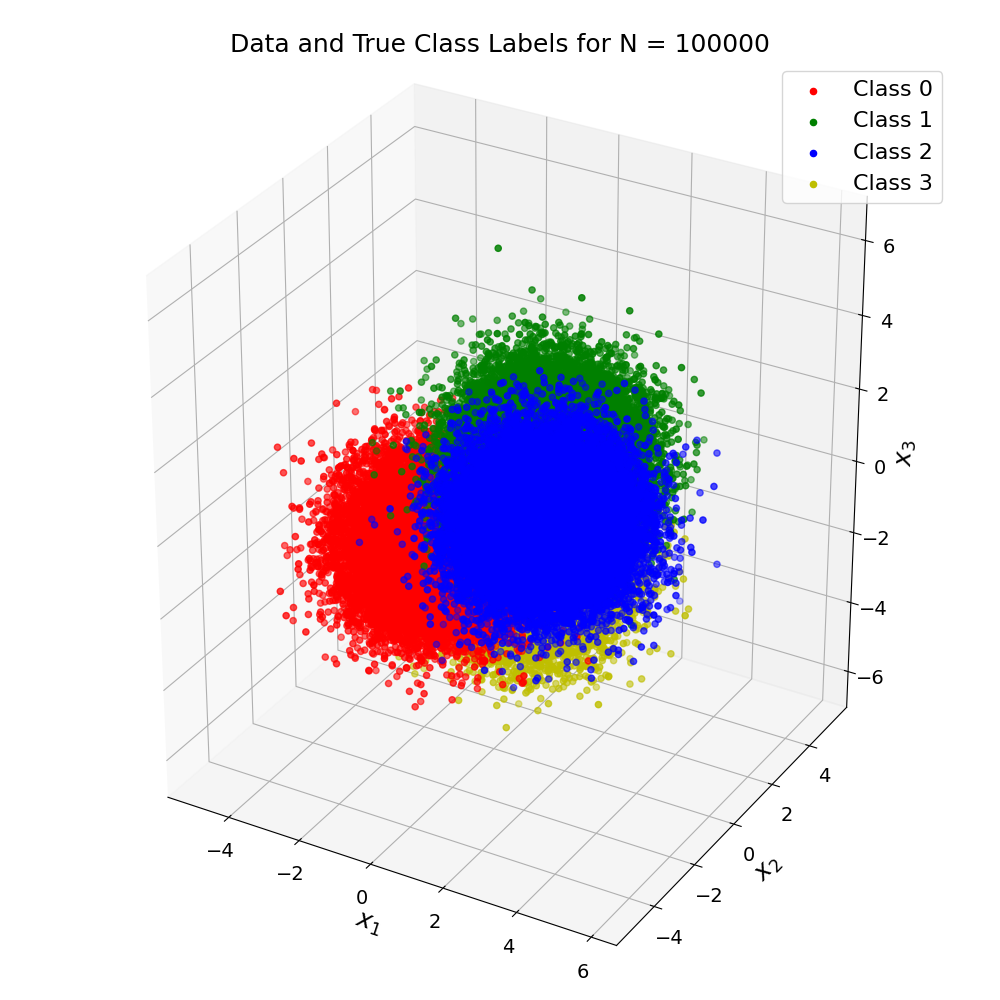

In [103]:
# Generate dataset from two different 3D Gaussian distributions/categories
gmm_pdf = {}

# Class priors
gmm_pdf['priors'] = np.array([0.25, 0.25, 0.25, 0.25])
num_classes = len(gmm_pdf['priors'])
L = np.array(range(num_classes))
C = np.size(L)

# # Mean and covariance of data pdfs conditioned on labels
# gmm_pdf['m'] = np.array([[1.3, 1.3, 0],
#                          [-1.3, 1.3, 0],
#                          [-1.3, -1.3, 0],
#                          [1.3, -1.3, 0]])  # Gaussian distributions means
gmm_pdf['m'] = np.array([[-1, -1, -1],
                         [1, 1, 1],
                         [2, -1, 0.5],
                         [0.5, 1, -2]])  # Gaussian distributions means
gmm_pdf['C'] = np.array([np.identity(3), np.identity(3), np.identity(3), np.identity(3)])  # Gaussian distributions covariance matrices

# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))
ax_raw = fig.add_subplot(111, projection='3d')

N = 100000

X, labels = generate_data_from_gmm(N, gmm_pdf)

plot_distribution(X, labels)

## Multilayer Neural Network

Let's now use [PyTorch](https://pytorch.org/) and put together an MLP that will be capable of separating the classes irrespective of the input's non-linearly separable space.

To begin with, we'll define an MLP class that consists of a single hidden layer (2-layer architecture altogether) with a ReLU activation function:

In [104]:
input_dim = X.shape[1]
n_hidden_neurons = 16 # <-- vary this
output_dim = C

# It's called an MLP but really it's not...
model = nn.Sequential(
    nn.Linear(input_dim, n_hidden_neurons),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons, output_dim),
    nn.LogSoftmax(dim=1)
)
# Visualize network architecture
print(model)
summary(model, input_size=(16, input_dim))

Sequential(
  (0): Linear(in_features=3, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=4, bias=True)
  (3): LogSoftmax(dim=1)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 16, 16]              64
              ReLU-2               [-1, 16, 16]               0
            Linear-3                [-1, 16, 4]              68
        LogSoftmax-4                [-1, 16, 4]               0
Total params: 132
Trainable params: 132
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [105]:
def model_train(model, data, labels, criterion, optimizer, num_epochs=25):
    # Apparently good practice to set this "flag" too before training
    # Does things like make sure Dropout layers are active, gradients are updated, etc.
    # Probably not a big deal for our toy network, but still worth developing good practice
    model.train()
    # Optimize the neural network
    for epoch in range(num_epochs):
        # These outputs represent the model's predicted probabilities for each class. 
        outputs = model(data)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, labels)
        # Set gradient buffers to zero explicitly before backprop
        optimizer.zero_grad()
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()
        
    return model


# Stochastic GD with learning rate and momentum hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to 
# the output when validating, on top of calculating the negative log-likelihood using 
# nn.NLLLoss(), while also being more stable numerically... So don't implement from scratch
criterion = nn.CrossEntropyLoss()
num_epochs = 25

# Convert numpy structures to PyTorch tensors, as these are the data types required by the library
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(labels)

# Trained model
model = model_train(model, X_tensor, y_tensor, criterion, optimizer, num_epochs=num_epochs)

Find the probability of error:

In [106]:
# def model_predict(model, data):
#     # Similar idea to model.train(), set a flag to let network know your in "inference" mode
#     model.eval()
#     # Disabling gradient calculation is useful for inference, only forward pass!!
#     with torch.no_grad():
#         # Evaluate nn on test data and compare to true labels
#         predicted_labels = model(data)
#         # Back to numpy
#         predicted_labels = predicted_labels.detach().numpy()

#         return np.argmax(predicted_labels, 1)
# # Z matrix are the predictions resulting from the forward pass through the network
# Z = model_predict(model, X_tensor)

In [107]:
def p_error(decisions, labels):
    print("Confusion Matrix (rows: Predicted class, columns: True class):")
    conf_mat = confusion_matrix(decisions, labels)
    print(conf_mat)

    correct_class_samples = np.sum(np.diag(conf_mat))
    print("Total Mumber of Misclassified Samples: {:d}".format(len(decisions) - correct_class_samples))

    prob_error = 1 - (correct_class_samples / len(decisions))
    print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))
    return prob_error

In [108]:
# ERM decisions:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
Lambda = np.ones((C, C)) - np.eye(C)

decisions = perform_erm_classification(X, Lambda, gmm_pdf, C)

print('MAP classifier:')
p_optimal = p_error(decisions, labels)

# print('MLP classsifier:')
# p_error(Z, labels)

MAP classifier:
Confusion Matrix (rows: Predicted class, columns: True class):
[[21749   602   875  2020]
 [  602 20103  2767  1254]
 [  854  2908 20635   568]
 [ 1953  1260   526 21324]]
Total Mumber of Misclassified Samples: 16189
Empirically Estimated Probability of Error: 0.1619


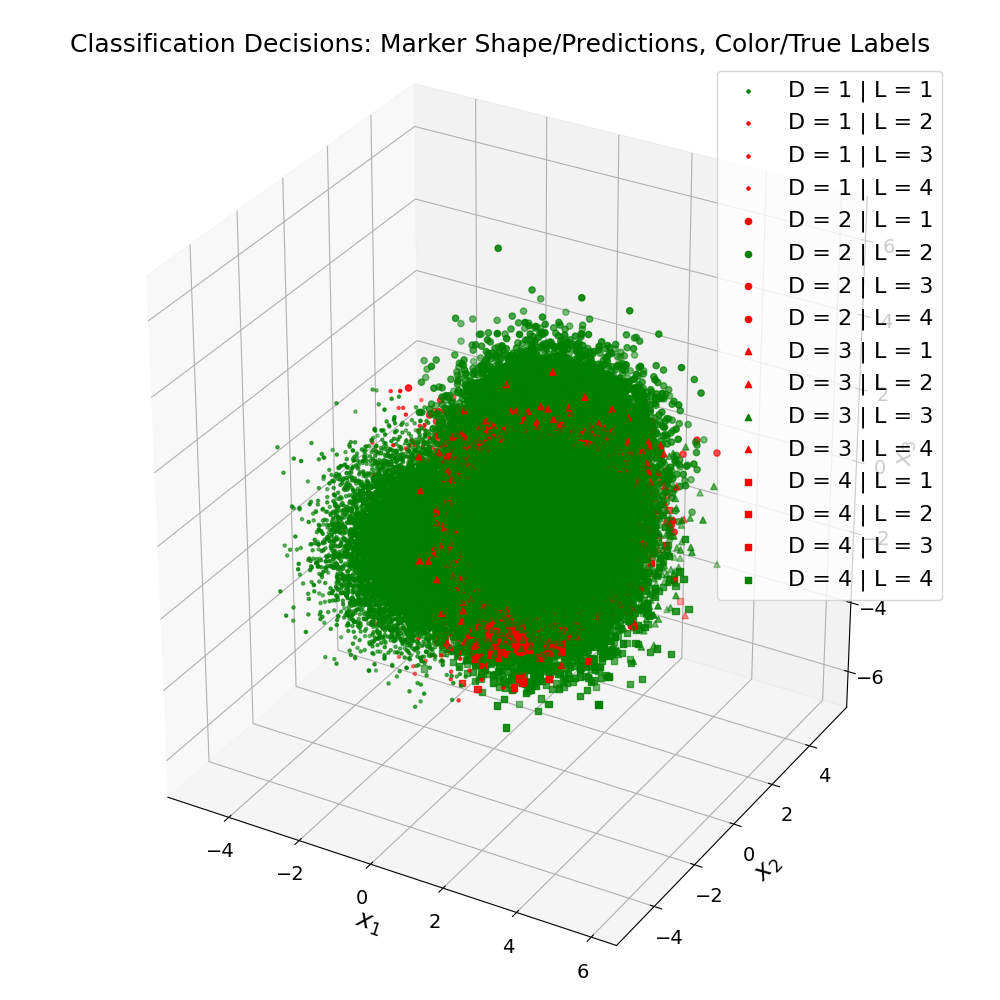

In [109]:
# Plot for decisions vs true labels
fig = plt.figure(figsize=(10, 10))

ax_2 = fig.add_subplot(111, projection='3d')

marker_shapes = '.o^s'
for r in L: # Each decision option
    for c in L: # Each class label
        ind_rc = np.argwhere((decisions==r) & (labels==c))

        # Decision = Marker Shape; True Labels = Marker Color
        if r == c:
            ax_2.scatter(X[ind_rc, 0], X[ind_rc, 1], X[ind_rc, 2], c='g', marker=marker_shapes[r],
                     label="D = {} | L = {}".format(r+1, c+1))
        else:
            ax_2.scatter(X[ind_rc, 0], X[ind_rc, 1], X[ind_rc, 2], c='r', marker=marker_shapes[r],
                     label="D = {} | L = {}".format(r+1, c+1))
plt.legend()
ax_2.set_ylabel(r"$x_2$")
ax_2.set_xlabel(r"$x_1$")
ax_2.set_zlabel(r"$x_3$")
ax_2.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(X[:, 2])))
plt.title("Classification Decisions: Marker Shape/Predictions, Color/True Labels")
plt.tight_layout()
plt.show()

In [110]:
def model_train_loader(model, dataloader, criterion, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        predictions = model(X)
        loss = criterion(predictions, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Report loss every 10 batches
        # if batch % 10 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
            
def model_test_loader(model, dataloader, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Tracking test loss (cross-entropy) and correct classification rate (accuracy)
    test_loss, correct = 0, 0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            predictions = model(X)
            test_loss += criterion(predictions, y)
            correct += (predictions.argmax(1) == y).type(torch.float).sum()
            
    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [111]:
def k_fold_analysis(N_train, N_valid, K, max_num_perceptrons):
    X_train, y_train = generate_data_from_gmm(N_train, gmm_pdf)
    X_valid, y_valid = generate_data_from_gmm(N_valid, gmm_pdf)

    input_dim = X_train.shape[1]
    output_dim = C

    # Perceptrons to evaluate 
    perceptrons = np.arange(1, max_num_perceptrons, dtype=int)
    n_perceptrons_evaluated = np.size(perceptrons)

    # STEP 1: Partition the dataset into K approximately-equal-sized partitions
    # Shuffles data before doing the division into folds (not necessary, but a good idea)
    kf = KFold(n_splits=K, shuffle=True) 

    # Allocate space for CV
    # No need for training loss storage too but useful comparison
    error_train_mk = np.empty((n_perceptrons_evaluated, K)) 
    error_valid_mk = np.empty((n_perceptrons_evaluated, K)) 

    index = 0
    # STEP 2: Try all polynomial orders between 1 (best line fit) and 21 (big time overfit) M=2
    for perceptron in perceptrons:

        n_hidden_neurons = perceptron # <-- vary this

        # K-fold cross validation
        k = 0
        # NOTE that these subsets are of the TRAINING dataset
        # Imagine we don't have enough data available to afford another entirely separate validation set
        for train_indices, valid_indices in kf.split(X_train):
            # Extract the training and validation sets from the K-fold split
            X_train_k = X_train[train_indices]
            y_train_k = y_train[train_indices]
            X_valid_k = X_valid[valid_indices]
            y_valid_k = y_valid[valid_indices]
            
            # Train model parameters

            # Convert numpy structures to PyTorch tensors, as these are the data types required by the library
            X_train_k_tensor = torch.FloatTensor(X_train_k)
            y_train_k_tensor = torch.LongTensor(y_train_k)
            X_valid_k_tensor = torch.FloatTensor(X_valid_k)
            y_valid_k_tensor = torch.LongTensor(y_valid_k)

            # Create your dataset objects
            train_data = TensorDataset(X_train_k_tensor,  y_train_k_tensor) 
            test_data = TensorDataset(X_valid_k_tensor, y_valid_k_tensor) 

            train_dataloader = DataLoader(train_data, batch_size=500, shuffle=True)
            test_dataloader = DataLoader(test_data, batch_size=64) # No need to shuffle...

            model = nn.Sequential(
                nn.Linear(input_dim, n_hidden_neurons),
                nn.ReLU(),
                nn.Linear(n_hidden_neurons, output_dim),
                nn.LogSoftmax(dim=1)
            )
            
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
            for t in range(num_epochs):
                # print(f"Epoch {t+1}\n-------------------------------")
                model_train_loader(model, train_dataloader, criterion, optimizer)
                model_test_loader(model, test_dataloader, criterion)

            # Trained model
            Z_probs_train = model(X_train_k_tensor).detach().numpy()
            Z_pred_train = np.argmax(Z_probs_train, 1)

            Z_probs_valid = model(X_valid_k_tensor).detach().numpy()
            Z_pred_valid = np.argmax(Z_probs_valid, 1)

            # Record error as well for this model and k-fold
            error_train_mk[index, k] = p_error(Z_pred_train, y_train_k)
            error_valid_mk[index, k] = p_error(Z_pred_valid, y_valid_k)
            k += 1
        index += 1

                
    # STEP 3: Compute the average MSE loss for that model (based in this case on degree d)
    # mse_train_m = np.mean(mse_train_mk, axis=1) # Model average CV loss over folds
    error_train_m = np.mean(error_train_mk, axis=1) 
    error_valid_m = np.mean(error_valid_mk, axis=1) 

    # +1 as the index starts from 0 while the degrees start from 1
    optimal_perceptron = perceptrons[np.argmin(error_valid_m)]
    # print('The best number of perceptrons is p ={}'.format(optimal_perceptron))

    return error_train_m, error_valid_m, perceptrons, optimal_perceptron


Confusion Matrix (rows: Predicted class, columns: True class):
[[13  0  1  1]
 [ 0  0  0  0]
 [ 7 25 21 22]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 56
Empirically Estimated Probability of Error: 0.6222
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [0 0 0 0]
 [1 4 3 2]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 7
Empirically Estimated Probability of Error: 0.7000
Confusion Matrix (rows: Predicted class, columns: True class):
[[15  0  2  5]
 [ 5 28 18 17]
 [ 0  0  0  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 47
Empirically Estimated Probability of Error: 0.5222
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 0 0 2]
 [0 2 4 1]
 [0 0 0 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 7
Empirically Estimated Probability of Error: 0.7000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [21 27 19 23]
 [ 0  0  0  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 63


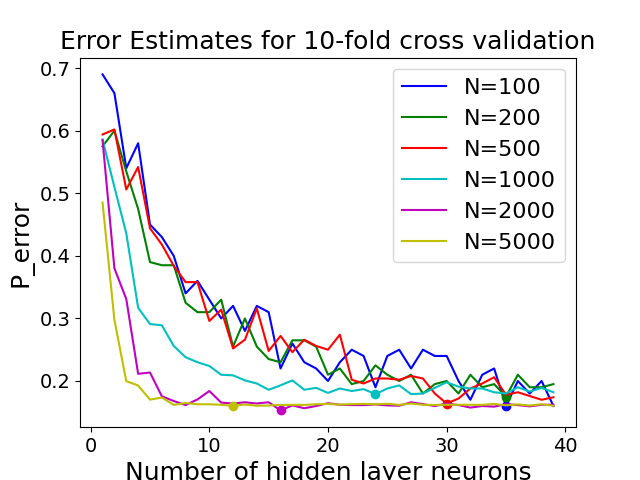

In [112]:
N_train_set = [100, 200, 500, 1000, 2000, 5000]
N_valid = 100000
K = 10 # Number of folds
n_sets = np.size(N_train_set)

fig, ax = plt.subplots()

n_perceptrons = 40

all_perceptrons = np.zeros((n_sets, n_perceptrons))
optimal_perceptrons = np.zeros(n_sets)
min_error = np.zeros(n_sets)


colors = 'bgrcmyk'

i= 0
for N_train in N_train_set:
    error_train_m, error_valid_m, perceptrons, optimal_perceptron = k_fold_analysis(N_train, N_valid, K, n_perceptrons)
    # plt.plot(perceptrons, error_train_m, label='D_train, N={}'.format(N_train))
    plt.plot(perceptrons, error_valid_m, label='N={}'.format(N_train), color=colors[i])
    plt.plot(optimal_perceptron, np.min(error_valid_m), marker = 'o', color=colors[i])
    optimal_perceptrons[i] = optimal_perceptron
    min_error[i] = np.min(error_valid_m)

    print('For N={}, optimal number of perceptrons is {}, producing p_error = {}'.format(N_train, optimal_perceptron, np.min(error_valid_m)))
    i +=1

plt.xlabel('Number of hidden layer neurons')
plt.ylabel('P_error')
plt.title('Error Estimates for 10-fold cross validation')
plt.legend()

Text(0.5, 1.0, 'Number of samples vs P_error')

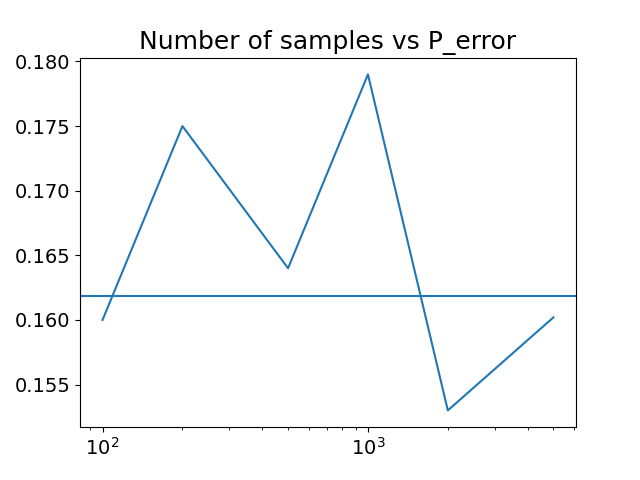

In [113]:
fig, ax = plt.subplots()
ax.set_xscale('log')
plt.plot(N_train_set, min_error)
plt.axhline(y=p_optimal)
plt.title('Number of samples vs P_error')

In [114]:
# K = 10

# X_train, y_train = generate_data_from_gmm(1000, gmm_pdf)
# X_valid, y_valid = generate_data_from_gmm(100000, gmm_pdf)

# input_dim = X_train.shape[1]
# output_dim = C

# # Perceptrons to evaluate 
# perceptrons = np.geomspace(1, 100, num=50, dtype=int)
# n_perceptrons_evaluated = np.size(perceptrons)

# # STEP 1: Partition the dataset into K approximately-equal-sized partitions
# # Shuffles data before doing the division into folds (not necessary, but a good idea)
# kf = KFold(n_splits=K, shuffle=True) 

# # Allocate space for CV
# # No need for training loss storage too but useful comparison
# error_train_mk = np.empty((n_perceptrons_evaluated, K)) 
# error_valid_mk = np.empty((n_perceptrons_evaluated, K)) 

# index = 0
# # STEP 2: Try all polynomial orders between 1 (best line fit) and 21 (big time overfit) M=2
# for perceptron in perceptrons:

#     n_hidden_neurons = perceptron # <-- vary this

#     # K-fold cross validation
#     k = 0
#     # NOTE that these subsets are of the TRAINING dataset
#     # Imagine we don't have enough data available to afford another entirely separate validation set
#     for train_indices, valid_indices in kf.split(X_train):
#         # Extract the training and validation sets from the K-fold split
#         X_train_k = X_train[train_indices]
#         y_train_k = y_train[train_indices]
#         X_valid_k = X_valid[valid_indices]
#         y_valid_k = y_valid[valid_indices]
        
#         # Train model parameters

#         # Convert numpy structures to PyTorch tensors, as these are the data types required by the library
#         X_train_k_tensor = torch.FloatTensor(X_train_k)
#         y_train_k_tensor = torch.LongTensor(y_train_k)
#         X_valid_k_tensor = torch.FloatTensor(X_valid_k)
#         y_valid_k_tensor = torch.LongTensor(y_valid_k)

#         # Create your dataset objects
#         train_data = TensorDataset(X_train_k_tensor,  y_train_k_tensor) 
#         test_data = TensorDataset(X_valid_k_tensor, y_valid_k_tensor) 

#         train_dataloader = DataLoader(train_data, batch_size=500, shuffle=True)
#         test_dataloader = DataLoader(test_data, batch_size=64) # No need to shuffle...

#         model = nn.Sequential(
#             nn.Linear(input_dim, n_hidden_neurons),
#             nn.ReLU(),
#             nn.Linear(n_hidden_neurons, output_dim),
#             nn.LogSoftmax(dim=1)
#         )
        
#         optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
#         for t in range(num_epochs):
#             print(f"Epoch {t+1}\n-------------------------------")
#             model_train_loader(model, train_dataloader, criterion, optimizer)
#             model_test_loader(model, test_dataloader, criterion)

#         # Trained model
#         Z_probs_train = model(X_train_k_tensor).detach().numpy()
#         Z_pred_train = np.argmax(Z_probs_train, 1)

#         Z_probs_valid = model(X_valid_k_tensor).detach().numpy()
#         Z_pred_valid = np.argmax(Z_probs_valid, 1)

#         # Record error as well for this model and k-fold
#         error_train_mk[index, k] = p_error(Z_pred_train, y_train_k)
#         error_valid_mk[index, k] = p_error(Z_pred_valid, y_valid_k)
#         k += 1
#     index += 1

            
# # STEP 3: Compute the average MSE loss for that model (based in this case on degree d)
# # mse_train_m = np.mean(mse_train_mk, axis=1) # Model average CV loss over folds
# error_train_m = np.mean(error_train_mk, axis=1) 
# error_valid_m = np.mean(error_valid_mk, axis=1) 

# # +1 as the index starts from 0 while the degrees start from 1
# optimal_perceptron = perceptrons[np.argmin(error_valid_m)]
# print('The best number of perceptrons is p ={}'.format(optimal_perceptron))


Text(0, 0.5, 'Optimal number of perceptrons')

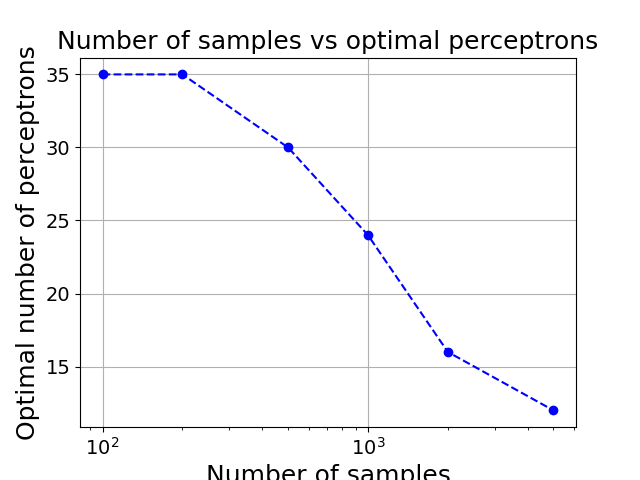

In [123]:
fig, ax = plt.subplots()
ax.set_xscale('log')
plt.plot(N_train_set, optimal_perceptrons, '--bo')
plt.title('Number of samples vs optimal perceptrons')
plt.grid()
plt.xlabel('Number of samples')
plt.ylabel('Optimal number of perceptrons')

In [124]:
def final_model_gen(N_train, N_valid, K, n_hidden_neurons):
    X_train, y_train = generate_data_from_gmm(N_train, gmm_pdf)
    X_valid, y_valid = generate_data_from_gmm(N_valid, gmm_pdf)

    input_dim = X_train.shape[1]
    output_dim = C

    # Convert numpy structures to PyTorch tensors, as these are the data types required by the library
    X_train_k_tensor = torch.FloatTensor(X_train)
    y_train_k_tensor = torch.LongTensor(y_train)
    X_valid_k_tensor = torch.FloatTensor(X_valid)
    y_valid_k_tensor = torch.LongTensor(y_valid)

    # Create your dataset objects
    train_data = TensorDataset(X_train_k_tensor,  y_train_k_tensor) 
    test_data = TensorDataset(X_valid_k_tensor, y_valid_k_tensor) 

    train_dataloader = DataLoader(train_data, batch_size=500, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=64) # No need to shuffle...

    model = nn.Sequential(
        nn.Linear(input_dim, n_hidden_neurons),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons, output_dim),
        nn.LogSoftmax(dim=1)
    )
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
    for t in range(num_epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        model_train_loader(model, train_dataloader, criterion, optimizer)
        model_test_loader(model, test_dataloader, criterion)

    # Trained model
    Z_probs_train = model(X_train_k_tensor).detach().numpy()
    Z_pred_train = np.argmax(Z_probs_train, 1)

    Z_probs_valid = model(X_valid_k_tensor).detach().numpy()
    Z_pred_valid = np.argmax(Z_probs_valid, 1)

    # Record error as well for this model and k-fold
    error = p_error(Z_pred_valid, y_valid)

    return error


Regenerate sets with optimal number of perceptrons:

In [132]:
error = np.zeros(n_sets)

i= 0
for N_train in N_train_set:
    n_hidden_neurons = int(optimal_perceptrons[i])

    # training 3 models using opt number of perceptrons:
    error_1 = final_model_gen(N_train, N_valid, K, n_hidden_neurons)
    error_2 = final_model_gen(N_train, N_valid, K, n_hidden_neurons)
    error_3 = final_model_gen(N_train, N_valid, K, n_hidden_neurons)
    
    error[i] = np.min([error_1, error_2, error_3]) #taking the min, prevents getting stuck in local minima

    print('For N={}, optimal number of perceptrons is {}, producing p_error = {}'.format(N_train, n_hidden_neurons, error[i]))
    i +=1

Confusion Matrix (rows: Predicted class, columns: True class):
[[18838   674   760   747]
 [  313 17288  1554   650]
 [  942  5131 22089   927]
 [ 4794  1902   778 22613]]
Total Mumber of Misclassified Samples: 19172
Empirically Estimated Probability of Error: 0.1917
Confusion Matrix (rows: Predicted class, columns: True class):
[[20552   296   633  2449]
 [  590 17133  1757   480]
 [ 1829  4614 20810   290]
 [ 2004  3183  1743 21637]]
Total Mumber of Misclassified Samples: 19868
Empirically Estimated Probability of Error: 0.1987
Confusion Matrix (rows: Predicted class, columns: True class):
[[22533   608  1327  5435]
 [  488 18826  1804  1585]
 [  879  4489 21721   579]
 [ 1000  1095   316 17315]]
Total Mumber of Misclassified Samples: 19605
Empirically Estimated Probability of Error: 0.1960
For N=100, optimal number of perceptrons is 35, producing p_error = 0.19172
Confusion Matrix (rows: Predicted class, columns: True class):
[[20364   871   809  1063]
 [  181 17546  2651   438]
 [ 

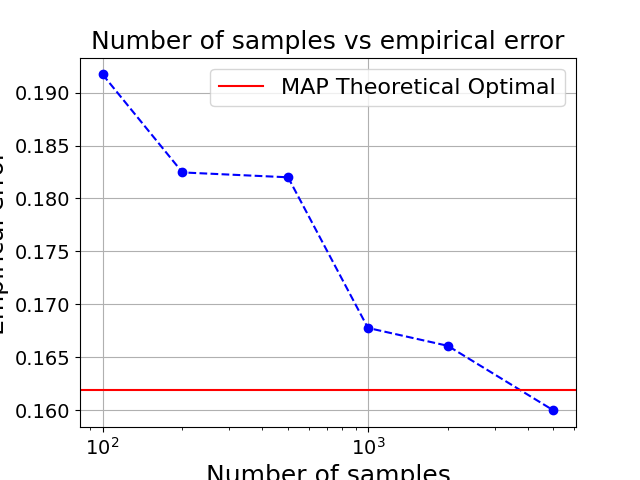

In [136]:
fig, ax = plt.subplots()
ax.set_xscale('log')
plt.plot(N_train_set, error, '--bo')
plt.title('Number of samples vs empirical error')
plt.grid()
plt.xlabel('Number of samples')
plt.ylabel('Empirical error')
plt.axhline(y=p_optimal, color='r', label='MAP Theoretical Optimal')
plt.legend()
plt.show()